# DESeq2 with miRNA counts table

[Resources] (http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

In [1]:
options(stringsAsFactors = FALSE)

Load required libraries (install packages if required)

In [2]:
library(ggplot2)
library(gplots)
library(data.table)
library(limma)
library(DESeq2)
library(RColorBrewer)
library(apeglm) 


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, ran

### Creating DESeq2 object

Read in counts file and view head of file

In [3]:
counts<-read.csv("data/Serum_ExoR_Nor_miRNA_counts.csv",header=TRUE,row.names=1)

In [4]:
head(counts)

,ExoRNeasy1_1,ExoRNeasy2_2,ExoRNeasy3_3,ExoRNeasy1_145,Nor1,Nor2,Nor3
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
hsa-miR-122-5p,2160,3274,3310,1986,95981,85210,358012
hsa-miR-486-5p,27142,39637,49572,26038,44072,40849,163263
hsa-miR-92a-3p,31034,46010,56577,18258,44786,30294,71414
hsa-miR-21-5p,143470,266112,277497,82365,88485,83749,145037
hsa-miR-423-5p,32979,51863,65891,28585,30736,33077,103540
hsa-let-7b-5p,60058,78710,112326,46062,41143,49977,55042


Make DESeq2 object: Define counts matrix, groups, and design

In [5]:
countData<-as.matrix(counts)
ncol(countData)
colData<-data.frame(condition=c(rep("ExoR",times=4),rep("Nor",times=3)))
dds <- DESeqDataSetFromMatrix(countData = countData, colData = colData, design = ~condition) 
dds
class(dds)

[1] 7

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 1826 7 
metadata(1): version
assays(1): counts
rownames(1826): hsa-miR-122-5p hsa-miR-486-5p ... hsa-miR-1179
  hsa-miR-514a-5p
rowData names(0):
colnames(7): ExoRNeasy1_1 ExoRNeasy2_2 ... Nor2 Nor3
colData names(1): condition

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

### Normalization

Calculate normalization factors and read out normalized counts file. DESeq2 doesn’t actually use normalized counts, rather it uses the raw counts and models the normalization inside the Generalized Linear Model (GLM). These normalized counts will be useful for downstream visualization of results, but cannot be used as input to DESeq2 or any other tools that peform differential expression analysis which use the negative binomial model.

In [6]:
dds <- estimateSizeFactors(dds)
sizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)
write.table(normalized_counts, file="DESeq2normalized_counts_ExoR_Nor.txt", sep="\t", quote=F, col.names=NA)

ExoRNeasy1_1   ExoRNeasy2_2   ExoRNeasy3_3 ExoRNeasy1_145           Nor1 
     0.8801363      1.4667151      1.6135819      0.6053482      0.7152907 
          Nor2           Nor3 
     0.7001388      1.8632511

### Run DESeq2 

In [7]:
#Run DESeq2 
dds<-DESeq(dds)

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



1. "alpha" is the significance cutoff used for optimizing the independent filtering (by default 0.1). If the adjusted p-value cutoff (FDR) will be a value other than 0.1, alpha should be set to that value. Here we have set alpha to 0.05.
2. Make table of results and order by adjusted p-value
3. Merge table with normalized coutns file and write out final table

In [8]:
##results dds
##alpha=0.05
res<-results(dds,contrast=c("condition","ExoR","Nor"),alpha=0.05)
##Make table of results
table(res$padj<0.05)
##Order by adjusted p-value
res <- res[order(res$padj),]
##Merge with normalized count data and write out table
resdata <- merge(as.data.frame(res), as.data.frame(counts(dds, normalized=TRUE)), by="row.names", sort=FALSE)
write.table(resdata,file="ExoR_Nor_DESeq2_resultsalpha0.05.txt",sep="\t")


FALSE  TRUE 
  326    80 

## Plots

### MA Plot
In DESeq2, the function plotMA shows the log2 fold changes attributable to a given variable over the mean of normalized counts for all the samples in the DESeqDataSet. Points will be colored red if the adjusted p value is less than 0.1. Points which fall out of the window are plotted as open triangles pointing either up or down.

In [9]:
#Log fold change shrinkage for visualization and ranking
resultsNames(dds)
resLFC <- lfcShrink(dds, coef="condition_Nor_vs_ExoR",type="apeglm")
resLFC

[1] "Intercept"             "condition_Nor_vs_ExoR"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



log2 fold change (MAP): condition Nor vs ExoR 
Wald test p-value: condition Nor vs ExoR 
DataFrame with 1826 rows and 5 columns
                        baseMean     log2FoldChange             lfcSE
                       <numeric>          <numeric>         <numeric>
hsa-miR-122-5p  65435.8881221889   5.88334320822601 0.205850082433218
hsa-miR-486-5p  48454.0879505869   1.04033893570209 0.199989540382794
hsa-miR-92a-3p  39437.5002050583  0.522285687023327 0.182771925039884
hsa-miR-21-5p   139092.040619273 -0.581206349790387 0.186195803353031
hsa-miR-423-5p  43809.8942061473  0.264647591719756 0.162765074418906
...                          ...                ...               ...
hsa-miR-6827-3p                0                 NA                NA
hsa-miR-888-5p                 0                 NA                NA
hsa-miR-4430                   0                 NA                NA
hsa-miR-1179                   0                 NA                NA
hsa-miR-514a-5p                0

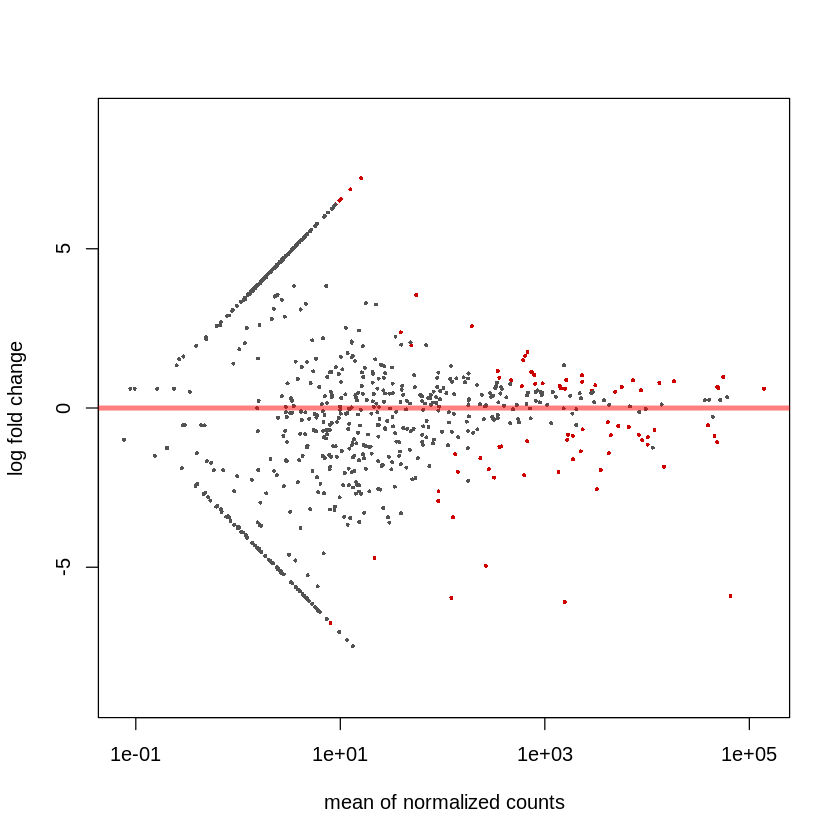

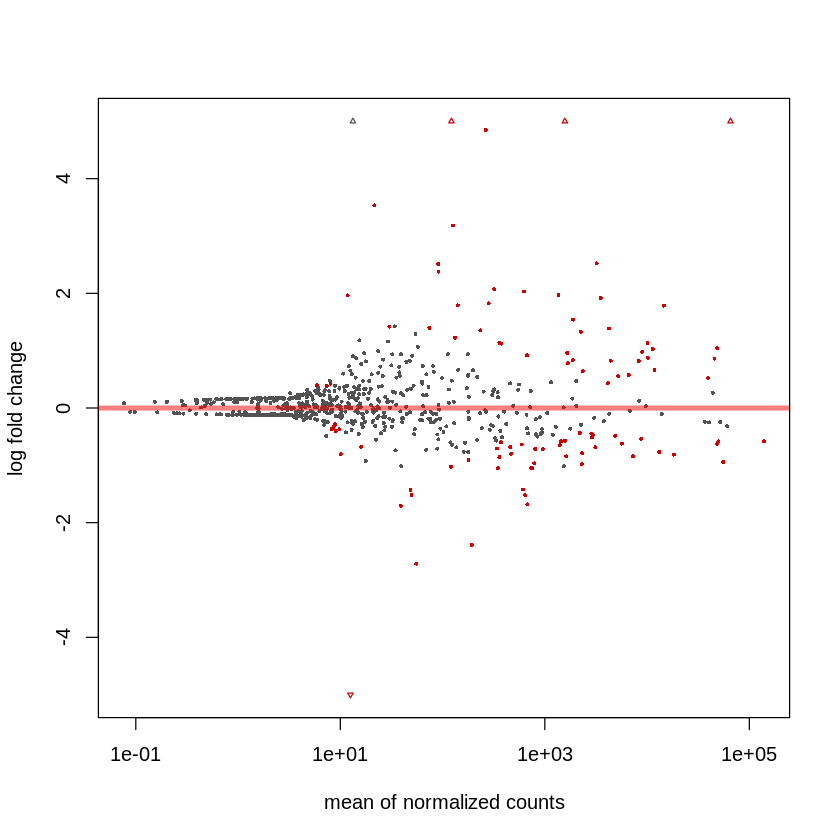

In [10]:
#MA plots
plotMA(res, ylim=c(-9,9))
##It is more useful visualize the MA-plot for the shrunken log2 fold changes, which remove the noise associated with log2 fold changes from low count genes without requiring arbitrary filtering thresholds.
plotMA(resLFC, ylim=c(-5,5))

### PCA Plot
Related to the distance matrix is the PCA plot, which shows the samples in the 2D plane spanned by their first two principal components. This type of plot is useful for visualizing the overall effect of experimental covariates and batch effects.

In [11]:
###function rlog returns a SummarizedExperiment object which contains the rlog-transformed values in its assay slot:
rld <- rlog(dds)
head(rld)

class: DESeqTransform 
dim: 6 7 
metadata(1): version
assays(1): ''
rownames(6): hsa-miR-122-5p hsa-miR-486-5p ... hsa-miR-423-5p
  hsa-let-7b-5p
rowData names(23): baseMean baseVar ... dispFit rlogIntercept
colnames(7): ExoRNeasy1_1 ExoRNeasy2_2 ... Nor2 Nor3
colData names(2): condition sizeFactor

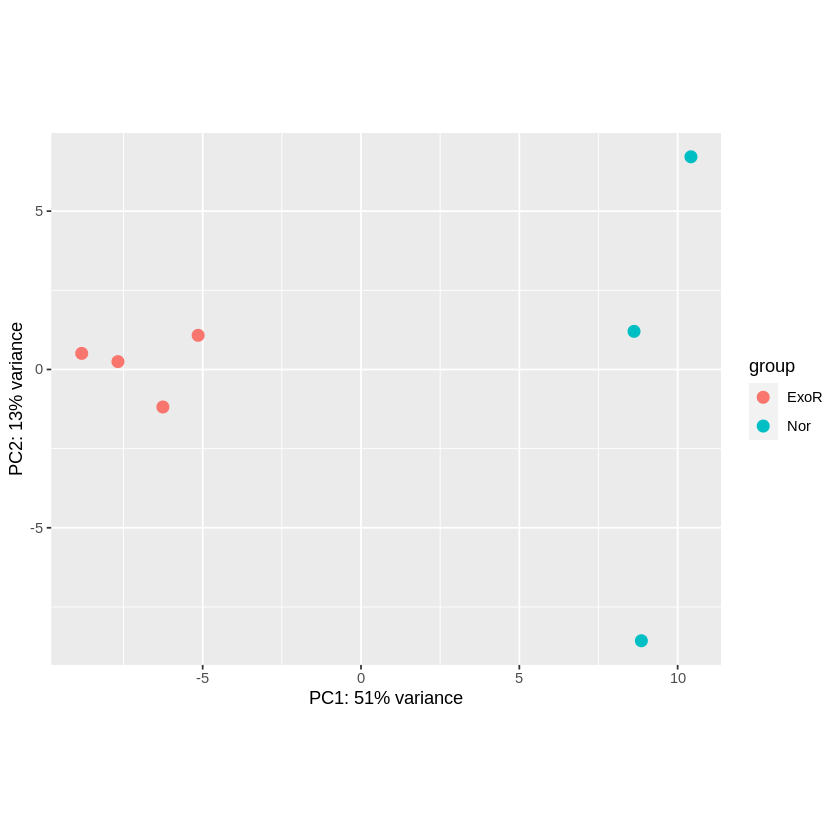

In [12]:
#plot PCA
plotPCA(rld, intgroup = c("condition"))

### Heatmap of sample-to-sample distances
A heatmap of this distance matrix gives us an overview over similarities and dissimilarities between samples. 


,ExoRNeasy1_1,ExoRNeasy2_2,ExoRNeasy3_3,ExoRNeasy1_145,Nor1,Nor2,Nor3
ExoRNeasy1_1,0.00000,12.47747,12.31002,14.09767,20.82881,21.27709,22.20730
ExoRNeasy2_2,12.47747,0.00000,11.52747,13.38446,18.84816,19.04437,20.50988
ExoRNeasy3_3,12.31002,11.52747,0.00000,13.64596,20.00993,20.37952,21.24133
ExoRNeasy1_145,14.09767,13.38446,13.64596,0.00000,18.70149,19.36251,20.17875
Nor1,20.82881,18.84816,20.00993,18.70149,0.00000,14.96434,14.95072
Nor2,21.27709,19.04437,20.37952,19.36251,14.96434,0.00000,15.92992
Nor3,22.20730,20.50988,21.24133,20.17875,14.95072,15.92992,0.00000


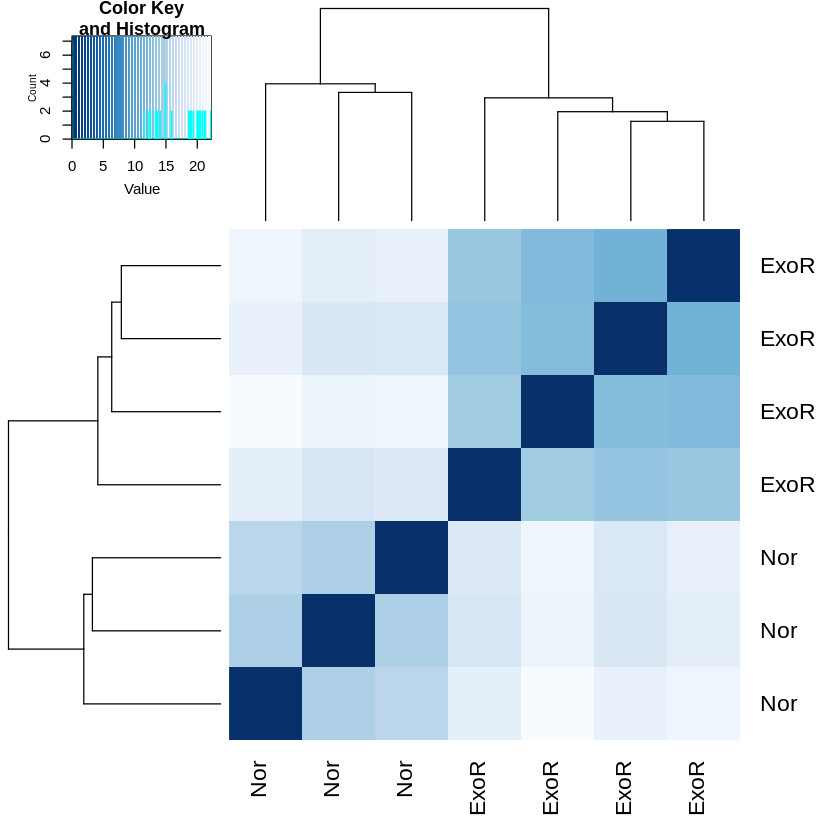

In [13]:
#visualize sample distances
sampleDists <- dist(t(assay(rld)))
as.matrix(sampleDists)[1:7,1:7]
sampleDistMatrix <- as.matrix(sampleDists)
rownames(sampleDistMatrix) <- paste(rld$condition, sep="-")
colnames(sampleDistMatrix) <- paste(rld$condition, sep="-")
colours = colorRampPalette(rev(brewer.pal(9, "Blues")))(255)
heatmap.2( sampleDistMatrix, trace="none", col=colours)

### Heatmap of miRNAs significantly different between groups
Make list of DE miRNAs and heatmap using heatmap.2

In [14]:
for_merge<-data.frame(read.delim("data/DESeq2_p0.05_80miRNAs.txt",header=TRUE,row.names=1))
miRNAs<-as.list(row.names(for_merge))
miRNAs_norm<-subset(normalized_counts,rownames(normalized_counts) %in% miRNAs)

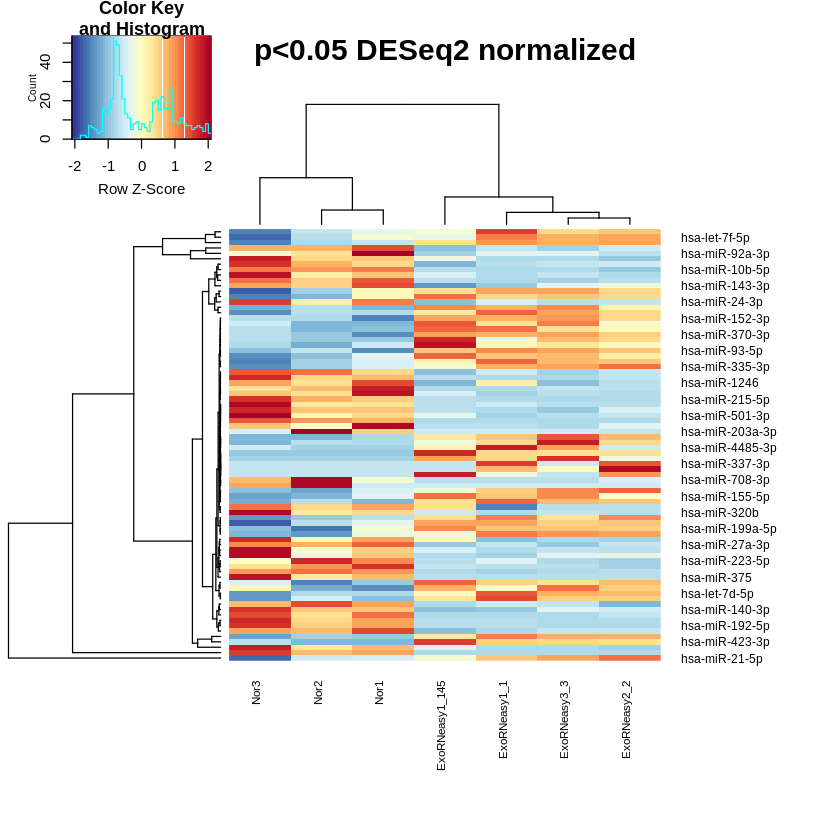

In [15]:
mypalette <- brewer.pal(11,"RdYlBu")
morecols <- colorRampPalette(mypalette)
heatmap.2(miRNAs_norm,col=rev(morecols(50)),trace="none", main="p<0.05 DESeq2 normalized",scale="row",margins=c(9,9), cexCol=0.7)

### Volcano plot
The volcano plot enables to simultaneously capture the effect size and significance (ordinate) of each tested gene.

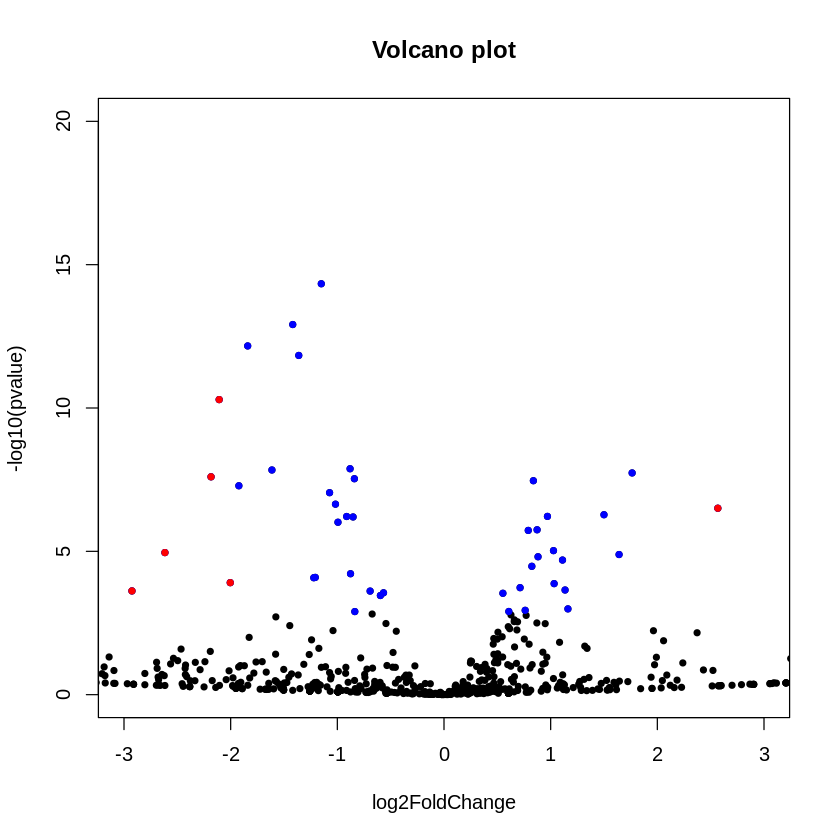

In [16]:
#volcano plot
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3),ylim=c(0,20)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))